#Classification: Spambase Data Set 
###Author: Ruiqi Liu
Data Repository: https://archive.ics.uci.edu/ml/datasets/Spambase

In [147]:
%matplotlib inline

# import necessary libraries  

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)

##Data Preprocessing
###Normalization

In [156]:
spam = np.genfromtxt('/Users/ruiqiliu/Desktop/MSBA/Fall/MSBA 6420 Predictive Analytics/Hw/spambase.csv',
                   delimiter=',')
spam.shape

(4601, 58)

In [157]:
#Shuffle and Split the data
from sklearn.cross_validation import KFold,train_test_split

spam = spam[np.random.permutation(len(spam))]
X_train,X_test,y_train,y_test = train_test_split(spam[:,0:56],
                                                 spam[:,57],
                                                 test_size = .2,random_state = 0)

Since all of the variables are in different range and are quite sketwed. To ensure classifiers like KNN to work, I first applied min-max scaler to fix the range.

In [158]:
from sklearn.preprocessing import MinMaxScaler 

min_max_scaler = MinMaxScaler()
X_train= min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

###Feature Selection

In [164]:
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 20 (0.068191)
2. feature 6 (0.058892)
3. feature 51 (0.056283)
4. feature 52 (0.051711)
5. feature 15 (0.045461)
6. feature 18 (0.042078)
7. feature 22 (0.041256)
8. feature 55 (0.039322)
9. feature 24 (0.038424)
10. feature 54 (0.036101)
11. feature 26 (0.030038)
12. feature 4 (0.029378)
13. feature 23 (0.026741)
14. feature 10 (0.025024)
15. feature 16 (0.022078)
16. feature 7 (0.021033)
17. feature 25 (0.020109)
18. feature 45 (0.019867)
19. feature 2 (0.018367)
20. feature 17 (0.017649)
21. feature 36 (0.017172)
22. feature 19 (0.016479)
23. feature 44 (0.016343)
24. feature 8 (0.016249)
25. feature 5 (0.015513)
26. feature 11 (0.015380)
27. feature 49 (0.015345)
28. feature 9 (0.014144)
29. feature 1 (0.012352)
30. feature 41 (0.011765)
31. feature 14 (0.010033)
32. feature 0 (0.009473)
33. feature 29 (0.009197)
34. feature 27 (0.008830)
35. feature 48 (0.008809)
36. feature 21 (0.007283)
37. feature 12 (0.007202)
38. feature 38 (0.006196)
39. feature 2

All Features except for feature 46 are somewhat important. So I decided to temporarely keep all features and apply feature selection in a pipeline afterward.

##Uniform Weighted Class

I performed 10 fold cross validation and used GridSearchCV to select the best parameters for the following models:

In [203]:
#Create classifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score,precision_score, recall_score,f1_score,roc_curve, auc)

classifiers = {'Logistic':LogisticRegression(),
               'Naive Bayes':GaussianNB(),
               'Support Vector Classification':SVC(),
               'Random Forest':RandomForestClassifier(),
               'KNN':KNeighborsClassifier(),
               }


In [206]:
#Set Parameters
svm_params = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100]},
             {'kernel': ['linear'], 'C': [1, 10, 100]}]

knn_params = {'n_neighbors':[5,10,30,50,100]}

log_params = {'penalty':['l1','l2']}

forest_params = {'max_depth': [5,10,30], 
                'n_estimators':[10,20], 
                'min_samples_split': [2,5,10]}
bayes_params = {}


params = {'Logistic': log_params,
          'Naive Bayes':bayes_params,
          'Support Vector Classification':svm_params,
          'Random Forest':forest_params,
          'KNN':knn_params,}


In [207]:
#Parameter selection + Cross Validation
from sklearn.cross_validation import KFold,train_test_split
from sklearn.grid_search import GridSearchCV

for (name, model), (name2,param) in zip(classifiers.items(),params.items()):
    print "%s:" % name
    clf = GridSearchCV(model, param, cv=10)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test) 
    print clf.best_params_
    print 
    

KNN:
{'n_neighbors': 5}

Support Vector Classification:
{'kernel': 'linear', 'C': 100}

Naive Bayes:
{}

Random Forest:
{'min_samples_split': 5, 'n_estimators': 20, 'max_depth': 30}

Logistic:
{'penalty': 'l1'}



In [208]:
#Evaluate Performance across all models

classifiers = {'Logistic':LogisticRegression(penalty = 'l1'),
               'Naive Bayes':GaussianNB(),
               'Support Vector Classification':SVC( kernel ='linear', C = 100),
               'Random Forest':RandomForestClassifier(min_samples_split = 5, n_estimators= 20, max_depth = 30),
               'KNN':KNeighborsClassifier(n_neighbors =5),
               }

for name, clf in classifiers.items():                  
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print "%s:" % name
    
    # Model performance is evaluated with accuracy, precision, recall and f-score
    print "\tAccuracy: %1.3f" % accuracy_score(y_test, y_pred)
    print "\tPrecision: %1.3f" % precision_score(y_test, y_pred)
    print "\tRecall: %1.3f" % recall_score(y_test, y_pred)
    print "\tF1: %1.3f\n" % f1_score(y_test, y_pred)

KNN:
	Accuracy: 0.907
	Precision: 0.894
	Recall: 0.865
	F1: 0.879

Support Vector Classification:
	Accuracy: 0.934
	Precision: 0.910
	Recall: 0.923
	F1: 0.916

Naive Bayes:
	Accuracy: 0.818
	Precision: 0.695
	Recall: 0.956
	F1: 0.805

Random Forest:
	Accuracy: 0.949
	Precision: 0.941
	Recall: 0.928
	F1: 0.935

Logistic:
	Accuracy: 0.914
	Precision: 0.901
	Recall: 0.878
	F1: 0.890



Considering that we don't want normal emails be classified as spam, I decided to reduce false positive rate. Therefore, I chose Random forest as my final model, which has both high accuracy and precision.



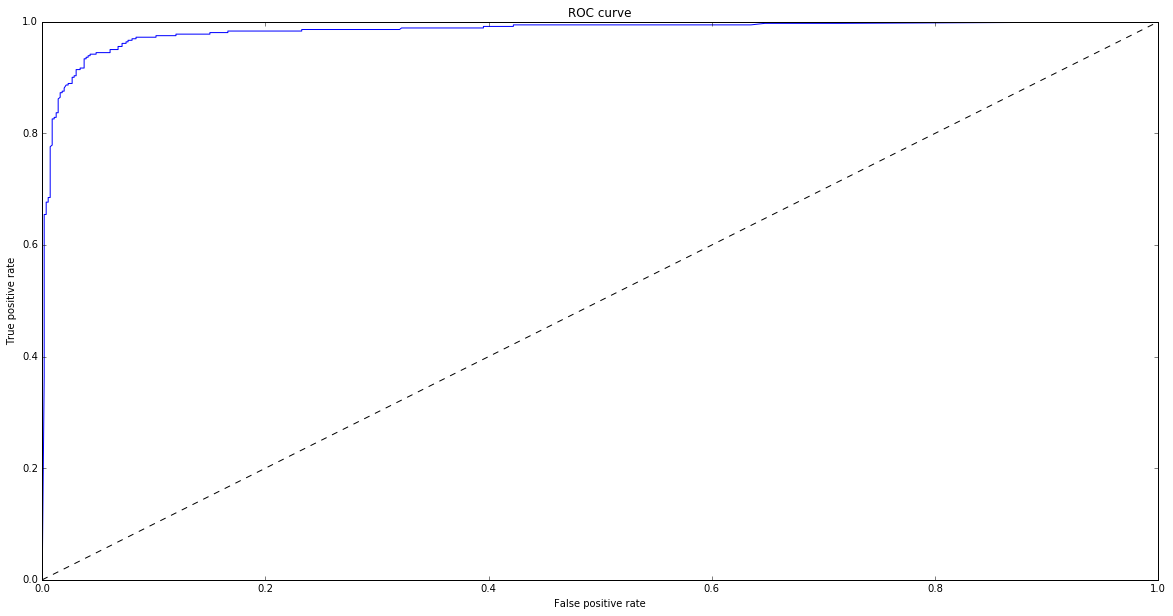

In [214]:
#The best model
best = RandomForestClassifier(min_samples_split = 5, n_estimators= 20, max_depth = 30)

#ROC
y_pred_rf = best.fit(X_train,y_train).predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

##Cost Sensitive 
I applied the same procedure for cost sensitvie model. 

In [226]:
#Create classifier

cs_classifiers = {'Logistic':LogisticRegression(class_weight={0: 10,1:1}),
               'Support Vector Classification':SVC(class_weight={0:10,1:1}),
               'Random Forest':RandomForestClassifier(class_weight={0:10,1:1}),
               }

In [227]:
#Set Parameters
svm_params = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100]},
             {'kernel': ['linear'], 'C': [1, 10, 100]}]


log_params = {'penalty':['l1','l2']}

forest_params = {'max_depth': [5,10,30], 
                'n_estimators':[10,20], 
                'min_samples_split': [2,5,10]}


params = {'Logistic': log_params,
          'Support Vector Classification':svm_params,
          'Random Forest':forest_params}

In [231]:
#Parameter selection + Cross Validation
from sklearn.cross_validation import KFold,train_test_split
from sklearn.grid_search import GridSearchCV

for (name, model), (name2,param) in zip(cs_classifiers.items(),params.items()):
    print "%s:" % name
    clf = GridSearchCV(model, param, scoring = 'precision', cv=10)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test) 
    print clf.best_params_
    print 
    

Support Vector Classification:
{'kernel': 'linear', 'C': 100}

Random Forest:
{'min_samples_split': 2, 'n_estimators': 20, 'max_depth': 30}

Logistic:
{'penalty': 'l1'}



In [237]:
#Evaluate Performance across all models

classifiers = {'Logistic':LogisticRegression(penalty = 'l1',class_weight= {0: 10,1:1}),
               'Support Vector Classification':SVC( kernel ='linear', C = 100,class_weight= {0: 10,1:1}),
               'Random Forest':RandomForestClassifier(min_samples_split = 5, n_estimators= 20,
                                                      max_depth = 30,class_weight= {0: 10,1:1}),
               }

for name, clf in classifiers.items():                  
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print "%s:" % name
    
    # Model performance is evaluated with accuracy, precision, recall and f-score
    print "\tAccuracy: %1.3f" % accuracy_score(y_test, y_pred)
    print "\tPrecision: %1.3f" % precision_score(y_test, y_pred)
    print "\tRecall: %1.3f" % recall_score(y_test, y_pred)
    print "\tF1: %1.3f\n" % f1_score(y_test, y_pred)

Support Vector Classification:
	Accuracy: 0.835
	Precision: 0.969
	Recall: 0.599
	F1: 0.741

Random Forest:
	Accuracy: 0.940
	Precision: 0.948
	Recall: 0.898
	F1: 0.922

Logistic:
	Accuracy: 0.814
	Precision: 0.975
	Recall: 0.541
	F1: 0.696



Although Logistic regression and SVM generates high precisions, their accuracies are worse than random forest. I chose random forest as the final model since it's well-balanced.

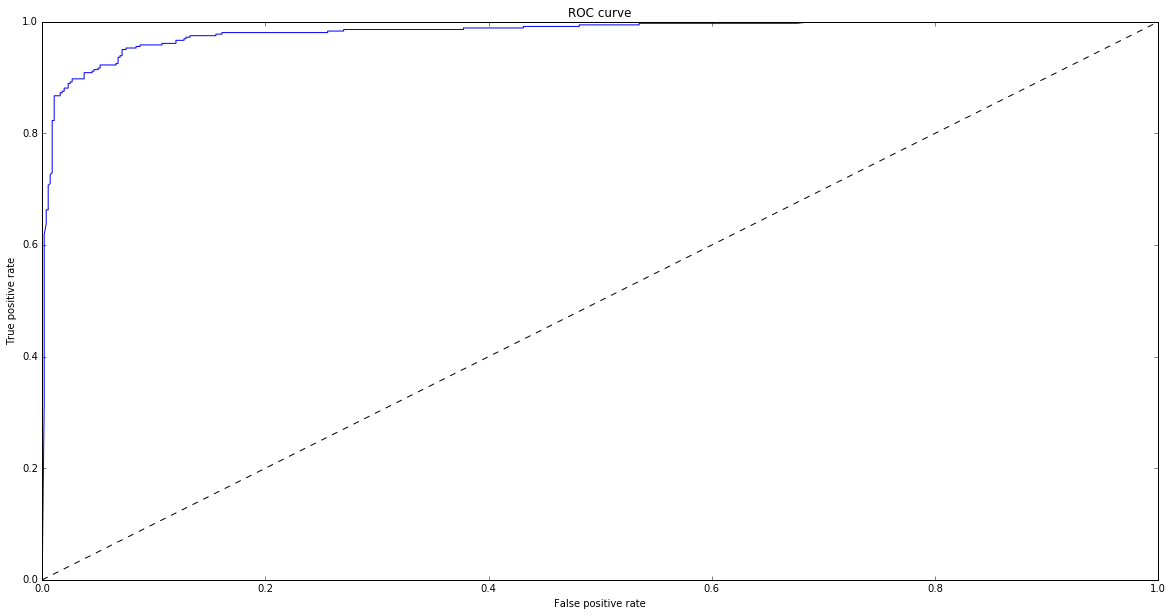

In [238]:
#The best model
cs_best = RandomForestClassifier(min_samples_split = 5, n_estimators= 20, max_depth = 30,class_weight= {0: 10,1:1})

#ROC
y_pred_rf = cs_best.fit(X_train,y_train).predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

##Conclusion

Random forest perferms great for general model and cost-sensitive classification model.

The performance for senario 1 is:
	Accuracy: 0.949
	Precision: 0.941
	Recall: 0.928
	F1: 0.935
    
The performance for senario 2 is:

	Accuracy: 0.940
	Precision: 0.948
	Recall: 0.898
	F1: 0.922